## Useful Tips

In this section, we discuss some of the useful mechanisms in simulus to help accomplish modeling tasks.

### Pseudo-Random Numbers

So far we have been using Python's `random` module to generate all the needed pseudo-random numbers in our examples. One can also use `numpy.random` to generate random numbers. Both generators use Mersenne twister, which has very good random properties. Using `numpy.random` has a couple of advantages: one is that it provides more random distributions; the other is that the numpy module can be used to generate numpy arrays vert efficiently. Of course, using `numpy.random` requires numpy to be installed. 

The following shows the single-server queue example which we discussed earlier, but this time, we use different random distributions for the inter-arrival time and the service time. We use a Pareto distribution for the arrivals and a Gamma distribution for services.

In [20]:
# %load '../examples/misc/mm1-numpy.py'
import numpy # assuming numpy has been installed
import simulus

numpy.random.seed(123)

def job(idx):
    r.acquire()
    print("%g: job(%d) gains access" % (sim.now,idx))
    sim.sleep(numpy.random.gamma(2, 2))
    print("%g: job(%d) releases" % (sim.now,idx))
    r.release()

def arrival():
    i = 0
    while True:
        i += 1
        sim.sleep(numpy.random.pareto(0.95))
        print("%g: job(%d) arrives" % (sim.now,i))
        sim.process(job, i)

sim = simulus.simulator()
r = sim.resource()
sim.process(arrival)
sim.run(10)


2.50792: job(1) arrives
2.50792: job(1) gains access
2.93383: job(2) arrives
3.71817: job(3) arrives
6.62659: job(1) releases
6.62659: job(2) gains access
7.3872: job(2) releases
7.3872: job(3) gains access
7.56079: job(3) releases


Actually, all our examples use the module's default random generator (`random` or `numpy.random`). All the functions supplied by the module are actually bound methods of a hidden instance of the corresponding class (`random.Random` or `numpy.random.RandomState`). Although it's OK for all the examples we have shown, there is a slight problem if we use the module-bound random generator:
* When we instantiate more than one simulators, they will share the random sequence. This means the simulation result may be different from running each simulator alone. This could make debugging difficult.
* When we run parallel and distributed simulation (as we will discuss later), if all simulation instances start with the same random seed, they would use the same random sequence. This is not a good idea because this would artificially introduce correlations among supposedly independent random processes.

Simulus provides an easy way to produce an independent random sequence at each simulator. The simulator's `rng()` method returns a random number generator that's attached to the simulator. There is one and only one such random number generator at each simulator. Internally, the generator is created with a seed taken from the `random` module's default random sequence (which is supposed to be seeded with the same constant), and the name of the simulator (which is supposed to be uniquely chosen by the user, or by simulus using the default random sequence if the simulator is created anonymously). Consequently, the random sequence will be consistant (across different runs and on differnt parallel machines) and guaranteed to be independent among simulators, as long as we use the same random seed to start the simulation. 

In [23]:
# %load '../examples/misc/mm1-simrng.py'
import numpy # assuming numpy has been installed
import random, simulus

# this determines the random module's default random sequence
random.seed(123)

def job(idx):
    r.acquire()
    print("%g: job(%d) gains access" % (sim.now,idx))
    sim.sleep(rng.gamma(2, 2))
    print("%g: job(%d) releases" % (sim.now,idx))
    r.release()

def arrival():
    i = 0
    while True:
        i += 1
        sim.sleep(rng.pareto(0.95))
        print("%g: job(%d) arrives" % (sim.now,i))
        sim.process(job, i)

sim = simulus.simulator('unique_name')
rng = numpy.random.RandomState(sim.rng().randrange(2**32))
r = sim.resource()
sim.process(arrival)
sim.run(10)


1.86502: job(1) arrives
1.86502: job(1) gains access
2.9371: job(2) arrives
3.00131: job(3) arrives
3.27486: job(4) arrives
3.79335: job(1) releases
3.79335: job(2) gains access
4.16708: job(5) arrives
4.36979: job(2) releases
4.36979: job(3) gains access
7.54389: job(6) arrives
7.60303: job(3) releases
7.60303: job(4) gains access
7.65806: job(7) arrives
8.32767: job(8) arrives
9.29563: job(4) releases
9.29563: job(5) gains access
9.56081: job(9) arrives


In the above example, we create a numpy random number generator `rng` and seed it using the simulator's attached generator. The simulator is also named. In this case, the random number sequence from `rng` is going to be dependent only on the initial random seed 123, regardless whether the simulator is running together with other simulators or as part of a parallel simulation on different ranks. 

### Statistical Data Collection

In [29]:
# %load '../examples/misc/mm1-dc.py'
import simulus, random

random.seed(123)

def job():
    r.acquire()
    sim.sleep(random.expovariate(1.1))
    r.release()

def arrival():
    while True:
        sim.sleep(random.expovariate(1))
        sim.process(job)

sim = simulus.simulator()

dc = simulus.DataCollector(
    arrivals='timemarks(all)', 
#    services='timemarks()',
#    reneges='timemarks', 
#    departs='timemarks(all)',
    inter_arrivals='runstats()',
#    queue_times='runstats',
#    renege_times='runstats',
    service_times='runstats',
    system_times='runstats(all)',
    in_systems='timeseries(all)',
#    in_services='timeseries',
    in_queues='timeseries(all)'
)
r = sim.resource(collect=dc)

sim.process(arrival)
sim.run(1000)
dc.report(sim.now)


arrivals (timemarks): samples=1001
  data=[0.053784393390292756, 0.1450082787542893, 0.2589614221257033] ...
  rate = 1.001
inter_arrivals (runstats): samples=1001
  mean = 0.998714
  stdev = 0.98983
  var = 0.979764
  min = 0.00034846
  max = 9.35352
service_times (runstats): samples=994
  mean = 0.868895
  stdev = 0.901727
  var = 0.813111
  min = 0.00299268
  max = 7.22985
system_times (runstats): samples=994
  data=[0.47542605365258694, 0.4195663293328595, 1.0040734156806599] ...
  mean = 5.9483
  stdev = 4.64295
  var = 21.557
  min = 0.00781643
  max = 21.8591
in_systems (timeseries): samples=1995
  data=[(0.053784393390292756, 1), (0.1450082787542893, 2), (0.2589614221257033, 3)] ...
  avg=5.93883
in_queues (timeseries): samples=1873
  data=[(0.053784393390292756, 0), (0.1450082787542893, 1), (0.2589614221257033, 2)] ...
  avg=5.07294


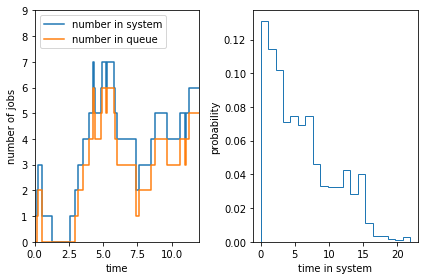

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, tight_layout=True)
insys = dc.in_systems.data()
inque = dc.in_queues.data()
axs[0].step(*zip(*insys), where='post', label="number in system")
axs[0].step(*zip(*inque), where='post', label="number in queue")
axs[0].set_xlim([0,12])
axs[0].set_ylim([0,9])
axs[0].set_xlabel('time')
axs[0].set_ylabel('number of jobs')
axs[0].legend(loc='upper left')

st = dc.system_times.data()
axs[1].hist(st, bins=20, density=True, histtype='step')
axs[1].set_xlabel('time in system')
axs[1].set_ylabel('probability')

plt.show()

In [33]:
# %load '../examples/misc/gas-dc.py'
import itertools, random, simulus

GAS_STATION_SIZE = 2000    # gas station reservoir size
GAS_PUMPS = 10             # number of gas pumps
REFUEL_THRESHOLD = 25      # min reservoir level (in %) before calling the tank truck
FUEL_TANK_SIZE = 50        # car's fuel task size
FUEL_TANK_LEVEL = [1, 15]  # min/max tank level before refueling
REFUELING_SPEED = 2        # speed of the pump
TANK_TRUCK_TIME = 300      # tank truck travel time
INTER_ARRIVAL = 5          # inter-arrival time of cars

def car_generator(sim, gas_station, fuel_pump):
    for i in itertools.count():
        sim.sleep(random.expovariate(1.0/INTER_ARRIVAL))
        sim.process(car, sim, gas_station, fuel_pump)

def car(sim, gas_station, fuel_pump):
    fuel_tank_level = random.randint(*FUEL_TANK_LEVEL)
    gas_station.acquire() # dumb wait
    liters_required = FUEL_TANK_SIZE - fuel_tank_level
    fuel_pump.get(liters_required) # another dumb wait
    sim.sleep(liters_required / REFUELING_SPEED)
    gas_station.release()

def gas_station_control(sim, fuel_pump):
    while True:
        if fuel_pump.level/fuel_pump.capacity*100 < REFUEL_THRESHOLD:
            sim.wait(sim.process(tank_truck, sim, fuel_pump))
        sim.sleep(10)  # check every 10 seconds

def tank_truck(sim, fuel_pump):
    sim.sleep(random.expovariate(1.0/TANK_TRUCK_TIME))
    amt = fuel_pump.capacity - fuel_pump.level
    fuel_pump.put(amt)

random.seed(123)
sim = simulus.simulator()
gas_station = sim.resource(GAS_PUMPS)
dc = simulus.DataCollector(
#    puts='timeseries(all)',
#    put_times='runstats(all)',
#    put_queues='timeseries(all)',
#    gets='timeseries(all)',
    get_times='runstats',
#    get_queues='timeseries(all)',
    levels='timeseries(all)'
)
fuel_pump = sim.store(GAS_STATION_SIZE, GAS_STATION_SIZE, collect=dc)
sim.process(gas_station_control, sim, fuel_pump)
sim.process(car_generator, sim, gas_station, fuel_pump)
sim.run(until=1000)
dc.report(sim.now)


get_times (runstats): samples=142
  mean = 26.6944
  stdev = 66.3762
  var = 4405.8
  min = 0
  max = 212.189
levels (timeseries): samples=113
  data=[(0, 2000), (0.26892196695146375, 1957), (0.7250413937714464, 1921)] ...
  avg=391.148


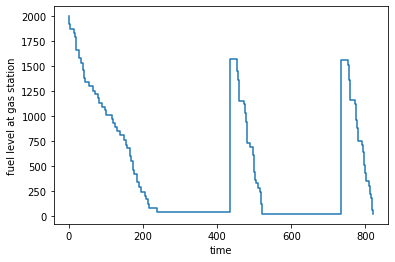

In [34]:
import matplotlib.pyplot as plt
levels = dc.levels.data()
plt.step(*zip(*levels), where='post')
plt.xlabel('time')
plt.ylabel('fuel level at gas station')
plt.show()

In [38]:
# %load '../examples/misc/delivery-dc.py'
import simulus

from random import seed, expovariate, randint
seed(12345)

def generate():
    num = 0
    while True:
        sim.sleep(expovariate(1))
        for _ in range(randint(1,5)): # send a bunch
            mb.send(num)
            num += 1

def get_one():
    while True:
        sim.sleep(1)
        msg = mb.recv(isall=False)

def get_all():
    while True:
        sim.sleep(5)
        msgs = mb.recv()

sim = simulus.simulator()
dc = simulus.DataCollector(messages='timeseries(all)')
mb = sim.mailbox(collect=dc)
sim.process(generate)
sim.process(get_one)
sim.process(get_all)
sim.run(22)
dc.report(sim.now)


messages (timeseries): samples=48
  data=[(0.5389162854563174, 1), (1, 0), (2.254685865860081, 2)] ...
  avg=6.45331


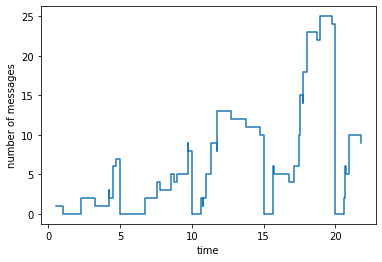

In [39]:
import matplotlib.pyplot as plt

msgs = dc.messages.data()
plt.step(*zip(*msgs), where='post')
plt.xlabel('time')
plt.ylabel('number of messages')
plt.show()
